In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import networkx as nx
import matplotlib.cm as cm
import re
import os
import pickle
import requests
import json
import urllib.request
from fa2 import ForceAtlas2
import powerlaw
import community
import math
import nltk
from nltk import word_tokenize
from nltk.book import *
from wordcloud import WordCloud

# Part A - Basic Stats


In [20]:
# create two functions that clean the names and links

def parse_links_from_file(file):
    links = set()
    for link in re.findall('\[\[([^\]]*)\]\]', file):
        if '|' in link:
            link = link.split('|')[0]
        links.add(link)
    return [link.lower() for link in links]

def parse_node(node):
    return node.split(".")[0].replace("_", " ").replace(" dc", "").replace(" marvel", "").lower()

In [21]:
# add nodes to the network
G = nx.DiGraph()

for i in os.listdir():
    if i.endswith(".txt"):
        with open(i, 'r') as f:
            file = f.read()
            if "dc" in i:
                G.add_node(parse_node(i), type='dc', file=i, words = len(re.findall(r'\w+', file)))
            else:
                G.add_node(parse_node(i), type='marvel', file=i, words = len(re.findall(r'\w+', file)))

In [22]:
#add edges to the network
edges = {}

for i in G.nodes(data=True):
    with open(i[1]['file'], 'r') as f:
        file = f.read()
        links = parse_links_from_file(file)
        edges[i[0]] = links

for name, edges in edges.items():
    for edge in edges:
        if edge in list(G.nodes):
            G.add_edge(*(name, edge))

In [23]:
#extract the largest component from the graph

G1 = max(nx.weakly_connected_components(G), key=len)

G1 = G.subgraph(G1)

**Write a short paragraph describing the network.**

* *The number of nodes and links.*

* *The average, median, mode, minimum and maximum value of the network's in-degree.s And of the out-degrees.*

In [24]:
print(nx.info(G1))
print("In-degrees",pd.Series([x[1] for x in list(G1.in_degree)]).describe())
print("Out-degrees:",pd.Series([x[1] for x in list(G1.out_degree)]).describe())

DiGraph with 1095 nodes and 9705 edges
In-degrees count    1095.000000
mean        8.863014
std        14.759976
min         0.000000
25%         2.000000
50%         4.000000
75%        10.000000
max       188.000000
dtype: float64
Out-degrees: count    1095.000000
mean        8.863014
std        24.248249
min         0.000000
25%         3.000000
50%         6.000000
75%        12.000000
max       768.000000
dtype: float64


The network consists of 2036 nodes and 27018 links. It can be seen from the in-degree stats above that some superheroes are mentioned a lot in other wikipedia pages, which means that they probably is very important for the universes as it is like popularity and as expected the out-degree is more constrained. The standard variation for in-degrees is around 26 which is much more than the standard variation for the out degree which is 15. Both out-degrees have a minimum value of 0, but the maximum value is way higher of in-degrees with 429 and a maximum of 116 of out-degrees. Furthermore, the median is higher for out-degrees with a value of 9, where in-degrees' median is 6. The stats indicate that especially in-degrees has a long tail and thus has a powerlaw distribution.

**We also want the degree distributions and a plot of the network**

- *Create in- and out-going degree distributions as described in Lecture 5.*


- *Estimate the slope of the incoming degree distribtion as described in Lecture 5.*


- *Plot the network using the Force Atlas algorithm as described in Lecture 5.*




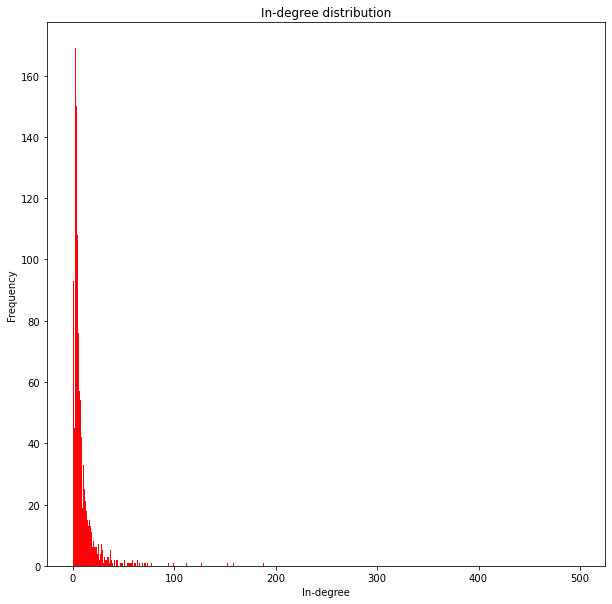

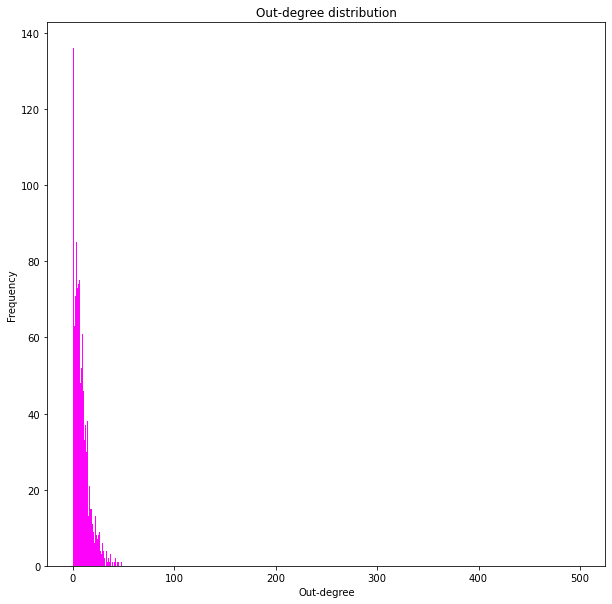

In [25]:
#create in-degree and out-degree distributions for the network

in_degree = list(dict(G1.in_degree()).values())
out_degree = list(dict(G1.out_degree()).values())

# plot the in-degree distribution

plt.figure(figsize=(10,10))
plt.hist(in_degree, bins=500, color='#FE0308', range=(0,500))
plt.title("In-degree distribution")
plt.xlabel("In-degree")
plt.ylabel("Frequency")
plt.show()

# plot the out-degree distribution

plt.figure(figsize=(10,10))
plt.hist(out_degree, bins=500, color='#FE03F9', range=(0,500))
plt.title("Out-degree distribution")
plt.xlabel("Out-degree")
plt.ylabel("Frequency")
plt.show()







The in-degrees has a way longer tail as expected

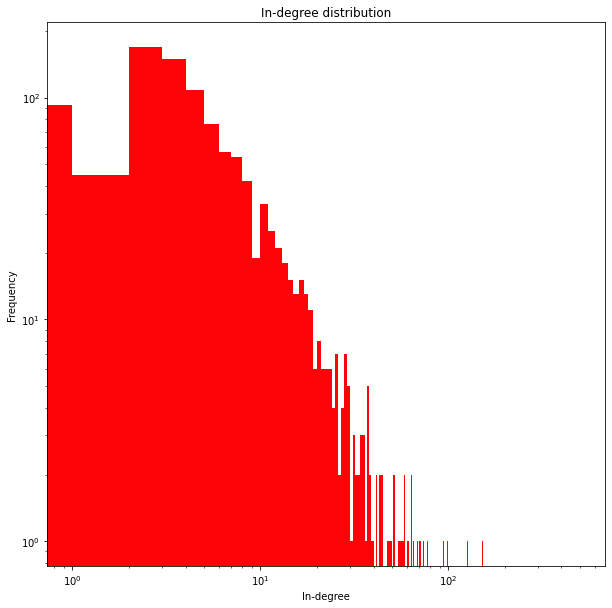

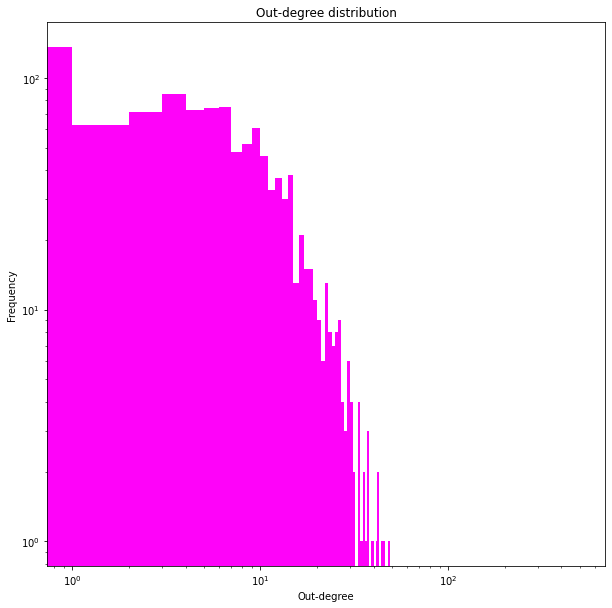

In [26]:
# plot the in-degree distribution with a log log scale

plt.figure(figsize=(10,10))
plt.hist(in_degree, bins=500, color='#FE0308', range=(0,500))
plt.title("In-degree distribution")
plt.xlabel("In-degree")
plt.ylabel("Frequency")
plt.xscale('log')
plt.yscale('log')
plt.show()

# plot the out-degree distribution with a log log scale

plt.figure(figsize=(10,10))
plt.hist(out_degree, bins=500, color='#FE03F9', range=(0,500))
plt.title("Out-degree distribution")
plt.xlabel("Out-degree")
plt.ylabel("Frequency")
plt.xscale('log')
plt.yscale('log')
plt.show()





- Estimate the slope of the incoming degree distribtion as described in Lecture 5.

In [27]:
#estimate, report, and reflect on the power law exponent for the in-degree distribution of the network

fit = powerlaw.Fit(in_degree)
alpha = fit.power_law.alpha
print("Power law exponent for the in-degree distribution of the network:", alpha)
print("Start point for the in-degree distribution of the network:", fit.power_law.xmin)

plt.figure(figsize=(12,12))




Calculating best minimal value for power law fit
Power law exponent for the in-degree distribution of the network: 2.8913541151300457
Start point for the in-degree distribution of the network: 24.0


Values less than or equal to 0 in data. Throwing out 0 or negative values


<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

In [28]:
fit = powerlaw.Fit(in_degree, xmin = 1.0)




Values less than or equal to 0 in data. Throwing out 0 or negative values


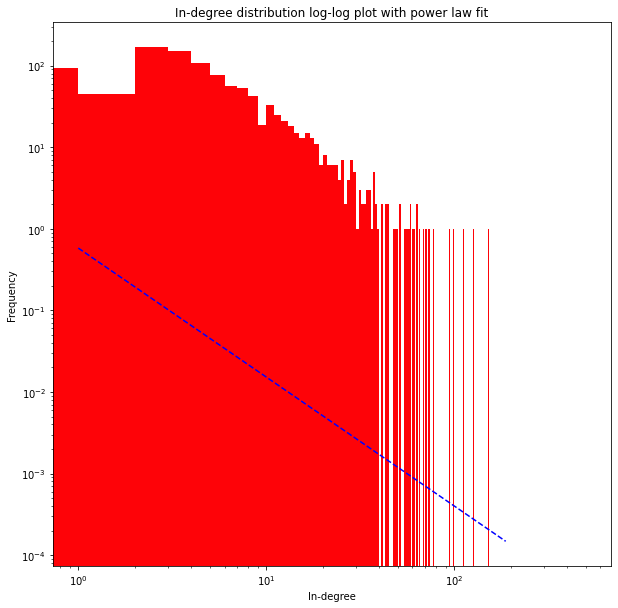

In [29]:
plt.figure(figsize=(10,10))
plt.hist(in_degree, bins=500, color='#FE0308', range=(0,500))
fit.power_law.plot_pdf(color='b',linestyle='--')
plt.title("In-degree distribution log-log plot with power law fit")
plt.xlabel("In-degree")
plt.ylabel("Frequency")
plt.show()

- Plot the network using the Force Atlas algorithm as described in Lecture 5.


In [30]:

colormap = []
for i in G1.nodes(data=True):
    if i[1]['type'] == 'dc':
        colormap.append('#192e75')
    else:
        colormap.append('#851515')

# add color to the edges 

edge_color = []
for i in G1.edges(data=True):
    if G1.nodes[i[0]]['type'] == 'dc' and G1.nodes[i[1]]['type'] == 'dc':
        edge_color.append('#718bde')
    elif G1.nodes[i[0]]['type'] == 'marvel' and G1.nodes[i[1]]['type'] == 'marvel':
        edge_color.append('#ed7e7e')
    else:
        edge_color.append('#ffbe33')


node_size = [G1.degree(i) * 0.5 for i in G1.nodes()] 

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 72.00it/s]


BarnesHut Approximation  took  0.44  seconds
Repulsion forces  took  0.88  seconds
Gravitational forces  took  0.00  seconds
Attraction forces  took  0.01  seconds
AdjustSpeedAndApplyForces step  took  0.03  seconds


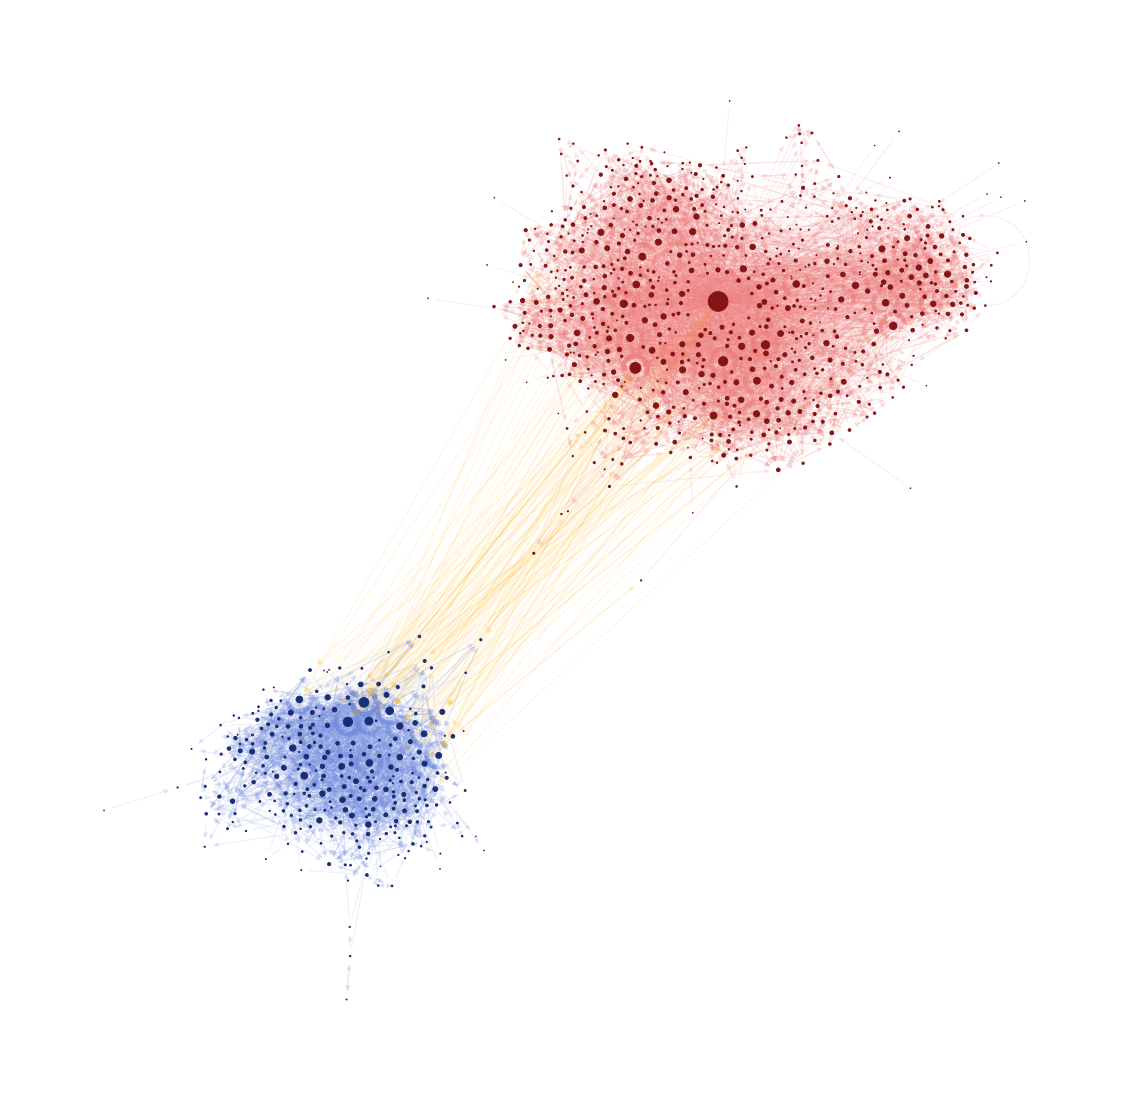

In [31]:
# draw the graph with force atlas 2 

forceatlas2 = ForceAtlas2(
                            # Behavior alternatives
                            outboundAttractionDistribution=False,  # Dissuade hubs
                            linLogMode=False,  # NOT IMPLEMENTED
                            adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                            edgeWeightInfluence=1.0,

                            # Performance
                            jitterTolerance=1.0,  # Tolerance
                            barnesHutOptimize=True,
                            barnesHutTheta=1.5,
                            multiThreaded=False,  # NOT IMPLEMENTED

                            # Tuning
                            scalingRatio=2.0,
                            strongGravityMode=False,
                            gravity=1.0,

                            # Log
                            verbose=True)

positions = forceatlas2.forceatlas2_networkx_layout(G1.to_undirected() , pos=None, iterations=100)

plt.figure(figsize=(20,20))
nx.draw_networkx_nodes(G1, positions, node_size=node_size, node_color=colormap) #, alpha=0.5) 
nx.draw_networkx_edges(G1, positions, edge_color=edge_color, alpha=0.15)
plt.axis('off')
plt.show()





# Part B - Communities

**Identify the communities in one or both of the superhero universes (DC/Marvel) as described in Week 7.**

In [32]:
#We need to make the network undirected
G1 = G1.to_undirected()

In [33]:
#Computing best partition
comms = community.best_partition(G1) 

In [34]:
#printing the number of communities
comms_values = list(comms.values())

size_communities = float(len(set(comms_values)))
print(size_communities)

8.0


In [35]:
#Computing the modularity
community.modularity(comms, G1)

0.49575270311241604

**Visualize the communities by coloring the graph's nodes according to community affiliation - also as described in Week 7.**

**Write a paragraph about your work to identify the communities. The paragraph should include**

* *Information about the algorithm you used to find communities.*
* *The value of modularity for your network.*
* *The number of communities and their sizes (in terms of number of nodes).*

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:26<00:00, 76.51it/s]


BarnesHut Approximation  took  6.98  seconds
Repulsion forces  took  17.63  seconds
Gravitational forces  took  0.13  seconds
Attraction forces  took  0.28  seconds
AdjustSpeedAndApplyForces step  took  0.56  seconds


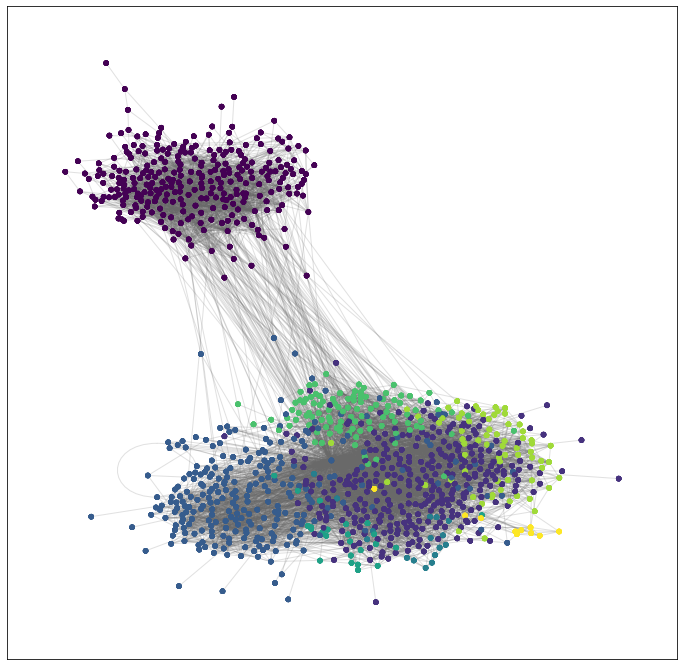

In [38]:
plt.figure(figsize=(12,12))
pos = forceatlas2.forceatlas2_networkx_layout(G1, pos=None, iterations=2000)
count = 0.
cmap = cm.get_cmap('viridis', max(comms.values()) + 1)
for com in set(comms.values()) :
    count = count + 1.
    list_nodes = [nodes for nodes in comms.keys()
                                if comms[nodes] == com]
    nx.draw_networkx_nodes(G1, pos, comms.keys(), node_size=20,
                     cmap=cmap, node_color=list(comms.values()))


communities=nx.draw_networkx_edges(G1, pos, alpha=0.2, edge_color="dimgray")

plt.show()

We used the Louvain algorithm to detect communities in the network of both the Marvel and DC universes. It maximizes the modularity score for each community, where the modularity quantifies the quality of an assignment of nodes to communities. This means evaluating how much more densely connected the nodes within a community are, compared to how connected they would be in a random network.

Ref: https://neo4j.com/docs/graph-data-science/current/algorithms/louvain/#:~:text=The%20Louvain%20method%20is%20an,assignment%20of%20nodes%20to%20communities.

The modularity value is calculated to 0.49575270311241604, which means that the communities are quite well partitioned. This can also be seen in the graph above. The communities are well grouped. 

We see that there is a total of 8 communities

**For the 10 largest communities, process the text in order to create a TF-IDF vector for each community. Explain in your own words how TF-IDF works.**

We were not able to exstract the communities with the belonging text, so we did the TF-IDF on both universes instead. Sorry for the mistake.

In [54]:
#We open the files and devide them into the different universes. 

with open('full_dc.txt', 'w') as outfile:
    
    for i in os.listdir():
        if i.endswith(".txt"):
            with open(i, 'r') as infile:
                if "dc" in i:
                    outfile.write(infile.read())
        
                outfile.write("\n")

In [55]:
#tokenize the words in each universe. 

raw = open('full_dc.txt').read()
dc_tokens = word_tokenize(raw)

In [57]:
#Put every word in lower case

words_dc = [w.lower() for w in dc_tokens if w.isalpha()]

In [58]:
#Removing stopwords
tokens_dc = FreqDist(words_dc)

stopwords = nltk.corpus.stopwords.words('english')
words = [w for w in tokens_dc]
for w in words: 
        if w in stopwords or not w.isalpha():
            tokens_dc.pop(w)

The TF - Term Frequency roughly mean number of terms in a document

In [59]:
def term_f(token_list):
    
    tf={}
    
    for word in token_list:
        if word in tf:
            tf[word] += 1
        else:
            tf[word] = 1
            
    for key in tf.keys():
        tf[key] = tf[key]/len(token_list)
    
    return tf

IDF - Inverse Document Frequency is defined by = log ( Total number of documents / (occurrence term in documents) )

IDF means how rare a term is in the collection of documents

In [60]:
#We are aware that common words can be in both universes. Uncommon words are log(2/1) and Common words are log(2/2)


In [63]:
def inverse_df(token_list,):
      
    idf={}
    
    for word in token_list:
        if word in idf:
            idf[word] =  math.log(2/2)
        else:
            idf[word] =  math.log(2/1)    
    
    return idf

The TF-IDF roughly means that a term is weighted in how relevant it is to the document. The TF-IDF multiplies both TF and IDF to give the words a score on the relevance. 

In [64]:
def tfidf(token_list):
    
    tfidf = {}
    
    tf = term_f(token_list)
    idf = inverse_df(token_list)
    
    for key, value in tf.items():
        tfidf[key] = value*idf[key]
    
    return tfidf

In [65]:
dc_tfidf = tfidf(tokens_dc)

In [67]:
dc_tfidf

{'comics': 2.5251263408376877e-05,
 'ref': 2.5251263408376877e-05,
 'dc': 2.5251263408376877e-05,
 'batman': 2.5251263408376877e-05,
 'category': 2.5251263408376877e-05,
 'cite': 2.5251263408376877e-05,
 'character': 2.5251263408376877e-05,
 'series': 2.5251263408376877e-05,
 'new': 2.5251263408376877e-05,
 'superman': 2.5251263408376877e-05,
 'characters': 2.5251263408376877e-05,
 'vol': 2.5251263408376877e-05,
 'justice': 2.5251263408376877e-05,
 'league': 2.5251263408376877e-05,
 'black': 2.5251263408376877e-05,
 'book': 2.5251263408376877e-05,
 'appears': 2.5251263408376877e-05,
 'comic': 2.5251263408376877e-05,
 'also': 2.5251263408376877e-05,
 'later': 2.5251263408376877e-05,
 'br': 2.5251263408376877e-05,
 'first': 2.5251263408376877e-05,
 'one': 2.5251263408376877e-05,
 'fictional': 2.5251263408376877e-05,
 'universe': 2.5251263408376877e-05,
 'version': 2.5251263408376877e-05,
 'time': 2.5251263408376877e-05,
 'woman': 2.5251263408376877e-05,
 'man': 2.5251263408376877e-05,
 '

**Then visualize the TF-IDF vectors using wordclouds (as described in Week 7). Remember to comment on your word-clouds (e.g. in the figure captions): Do the wordclouds/TF-IDF lists enable you to understand the communities you have found (or is it just gibberish)? Justify your answer.**

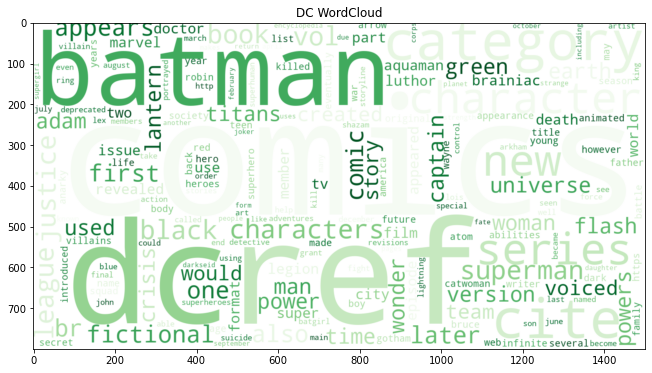

In [66]:
plt.figure(figsize=(12,6))
dc_wc = WordCloud(background_color="white", width=1500, height=800, 
                     colormap = 'Greens')
dc_wc.generate_from_frequencies(dc_tfidf)

plt.imshow(dc_wc, interpolation="bilinear")
plt.title('DC WordCloud')
plt.show()

We can see that Anarky and Shazam are very important in the DC universe according to our wordcloud. However, this do not help us understand the universe that well. As fans of both DC and Marvel, we were quite surprised by the result.  

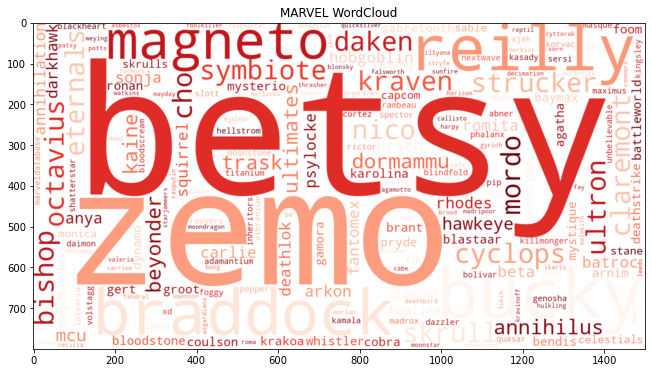

In [49]:
plt.figure(figsize=(12,6))
marvel_wc = WordCloud(background_color="white", width=1500, height=800, 
                     colormap = 'Reds')
marvel_wc.generate_from_frequencies(marvel_tfidf)

plt.imshow(marvel_wc, interpolation="bilinear")
plt.title('MARVEL WordCloud')
plt.show()

We that Betsy, Zemo and Bucky are very relevant. However, this is the same case as for DC. As fans this do not help us understand the universe better.

This is also a bad side of the TF-IDF as it doesnt weight the words in a semantic way and evaluate the words in that sense.